<a href="https://colab.research.google.com/github/alirezaght/iran-bank-card-ocr/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install yolov5

In [3]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 9893, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 9893 (delta 51), reused 55 (delta 30), pack-reused 9801
Receiving objects: 100% (9893/9893), 10.36 MiB | 25.31 MiB/s, done.
Resolving deltas: 100% (6837/6837), done.
/content/yolov5
     |████████████████████████████████| 596 kB 4.8 MB/s 
Setup complete. Using torch 1.10.0+cu111 (CPU)


In [4]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Prepare data

Check the graphic driver

In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Set Path

In [6]:
path = 'drive/MyDrive/Colab Notebooks/data'


## Remove unlabeld images


In [9]:
%cd /content
import json

def remove_unlabeled_files():
  labels = os.listdir(f'{path}/labels')
  images = os.listdir(f'{path}/images')
  for image in images:
    found = False
    for label in labels:
      if label.startswith(image.split('.')[0]):
        found = True
        break
    if not found:
      os.remove(f'{path}/images/{image}')
      print(f"Removed file {image}")

remove_unlabeled_files()


/content
Removed file 1d990127-Untitled.png
Removed file 8cc53e46-9.jpg
Removed file 38e94039-IMG_9586.JPG
Removed file 0beef3ca-14.jpg
Removed file 972a16d7-11.jpg
Removed file 4f95060b-2.jpg
Removed file 1a91f5e2-7.jpg
Removed file 852ff48a-images.jpg
Removed file c66a4672-IMG_9586.jpg
Removed file 4d938865-6.jpg
Removed file fd8c0f55-8.jpg
Removed file 9420eaf6-5.jpg
Removed file 48573584-IMG_9587.JPG
Removed file 92623880-facilities-tab-1.png
Removed file 02e6a41f-2726436.jpeg
Removed file 8c49700e-download.jpg
Removed file c779c1b1-1.jpg
Removed file 6e0c6f35-IMG_9586.jpg
Removed file 706ca31e-13.jpg
Removed file 65f2e012-12.jpg
Removed file 35b57267-10.jpg
Removed file 2de80f16-IMG_9586.jpg
Removed file 8ce6577a-4.jpg
Removed file 94c0fe9c-IMG_9587.jpg
Removed file 0912a554-IMG_9586.jpg
Removed file f5f71adc-3.jpg
Removed file bd782069-IMG_9587.jpg


## Prepare annotations and images

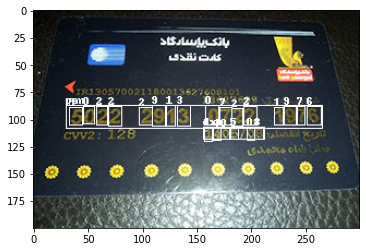

In [10]:
random.seed(0)

def prepare_labels():
  labels = {}
  notes = open(f'{path}/notes.json')
  categories = json.load(notes)['categories']
  for item in categories:
    labels[item['id']] = item['name']
  return labels

def get_image(label_file):
  list_images = {x.split('.')[0]:x for x in os.listdir(f'{path}/images')}  
  image_name = label_file.split('.')[0]    
  if image_name in list_images:
      return f'{path}/images/{list_images[image_name]}'


class_id_to_name_mapping = prepare_labels()

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

annotations = os.listdir(f'{path}/labels/')

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(f'{path}/labels/{annotation_file}', "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = get_image(annotation_file)
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

## Prepare train, validation, test set

In [11]:
# Read images and annotations
images = [os.path.join(f'{path}/images', x) for x in os.listdir(f'{path}/images')]
annotations = [os.path.join(f'{path}/labels', x) for x in os.listdir(f'{path}/labels')]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

### Copy to required folders

In [14]:
!mkdir images labels images/train images/val images/test labels/train labels/val labels/test

#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            print(f"Copying {f} to {destination_folder}")
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')


mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘labels’: File exists
mkdir: cannot create directory ‘images/train’: File exists
mkdir: cannot create directory ‘images/val’: File exists
mkdir: cannot create directory ‘images/test’: File exists
mkdir: cannot create directory ‘labels/train’: File exists
mkdir: cannot create directory ‘labels/val’: File exists
mkdir: cannot create directory ‘labels/test’: File exists
Copying drive/MyDrive/Colab Notebooks/data/images/bd64a25d-WhatsApp_Image_2021-11-09_at_1.28.19_PM.jpeg to images/train
Copying drive/MyDrive/Colab Notebooks/data/images/0b569f65-WhatsApp_Image_2021-11-09_at_1.38.50_PM_1.jpeg to images/train
Copying drive/MyDrive/Colab Notebooks/data/images/6f5c8103-20211109_102950.jpg to images/train
Copying drive/MyDrive/Colab Notebooks/data/images/8abe52e7-20211109_103012.jpg to images/train
Copying drive/MyDrive/Colab Notebooks/data/images/6068d95c-x_3.jpeg to images/train
Copying drive/MyDrive/Colab No

## Prepare the yaml file for yolo

In [15]:
import yaml

scanner_yaml = {"train": "/content/images/train/", "val": "/content/images/val/", "test": "/content/images/test/", "nc": len(class_id_to_name_mapping), "names": list(class_id_to_name_mapping.values())}

with open(r'/content/yolov5/data/scanner.yaml', 'w') as file:
    yaml.dump(scanner_yaml, file)

# Train

In [ ]:
%cd /content/yolov5
!python train.py --img 300 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 32 --epochs 100 --data scanner.yaml --weights yolov5s.pt --workers 24 --name yolo_scanner


/content/yolov5
train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=scanner.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=32, imgsz=300, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=yolo_scanner, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-86-g7473f0f torch 1.10.0+cu111 CPU

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, 

# Evaluate

In [ ]:
!python detect.py --source /content/images/test/ --weights runs/train/yolo_scanner/weights/best.pt --conf 0.25 --name yolo_scanner


## Plot randomly

In [ ]:
detections_dir = "runs/detect/yolo_scanner/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

## Compute mAP (mean average percision)

In [ ]:
!python test.py --weights runs/train/yolo_scanner/weights/best.pt --data scanner.yaml --task test --name yolo_det
